In [1]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind


from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
sc = StandardScaler()

In [34]:
import pandas as pd

# Carica le tabelle
prima_tabella = pd.read_csv('/Users/alessiamenozzi/Desktop/features_blocchi_nuove.csv')  # La prima tabella con paziente, blocco e features
seconda_tabella = pd.read_csv('/Users/alessiamenozzi/Desktop/ThesisPlaques/data_rad_clin_DEF.csv')     # La seconda tabella con paziente, label ecc.

# Uniformiamo i nomi dei pazienti della prima tabella al formato della seconda tabella
prima_tabella['paziente'] = prima_tabella['paziente'].apply(lambda x: f'patient_TC_{x}')

# Estrai solo i pazienti presenti nella prima tabella
pazienti_prima_tabella = prima_tabella['paziente'].unique()

# Filtra la seconda tabella per includere solo i pazienti presenti nella prima tabella
seconda_tabella_filtrata = seconda_tabella[seconda_tabella['IDs_new'].isin(pazienti_prima_tabella)]

# Crea un dizionario per mappare ogni paziente al valore della colonna 'label' (Sintomatico: 1 o 0)
mappa_sintomatico = dict(zip(seconda_tabella_filtrata['IDs_new'], seconda_tabella_filtrata['label']))

# Aggiungi la colonna 'Sintomatico' alla prima tabella basandoti sulla mappa creata
prima_tabella['Sintomatico'] = prima_tabella['paziente'].map(mappa_sintomatico)

# Salva la nuova tabella con la colonna aggiunta
prima_tabella.to_csv('/Users/alessiamenozzi/Desktop/features_blocchi_con_sintomatico.csv', index=False)

# Stampa una parte della tabella per verificare
print(prima_tabella.head())


       paziente  blocco  original_shape_Elongation  original_shape_Flatness  \
0  patient_TC_5    1654                   0.584950                 0.208036   
1  patient_TC_5    1926                   0.444117                 0.270250   
2  patient_TC_5    1925                   0.477231                 0.324920   
3  patient_TC_5    1910                   0.495727                 0.259487   
4  patient_TC_5    1670                   0.422262                 0.378551   

   original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                        4.695919                       22.572575   
1                        8.889544                       32.893824   
2                        2.935849                        9.035614   
3                        4.971501                       19.158960   
4                       12.615893                       33.326762   

   original_shape_Maximum2DDiameterColumn  \
0                               27.459060   
1                   

## clusterizzazione
Imputazione: Utilizziamo SimpleImputer con la strategia di imputazione della media (strategy='mean') per riempire i valori NaN.
PCA: Dopo aver gestito i NaN, riduciamo la dimensionalità delle features a 2 componenti per poterle visualizzare facilmente su un grafico bidimensionale. C'è SOLO UN VALORE DI NAN
K-Means: Applichiamo l'algoritmo di clustering K-Means sui dati trasformati dal PCA.
Visualizzazione: I risultati del clustering sono visualizzati con un grafico a dispersione (scatter plot).


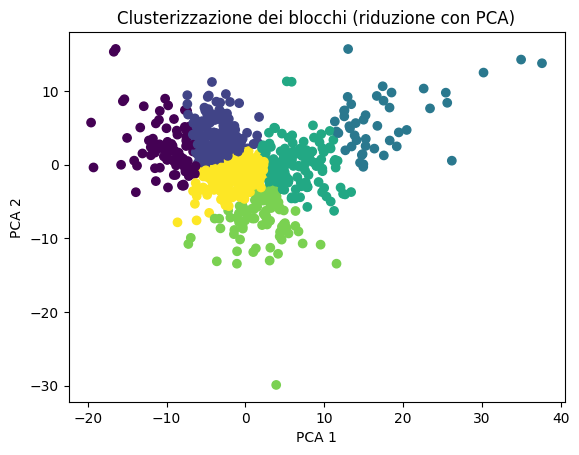

In [36]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


features = prima_tabella.drop(columns=['paziente', 'blocco', 'Sintomatico']).values

scaler = StandardScaler()
features = scaler.fit_transform(prima_tabella.drop(columns=['paziente', 'blocco', 'Sintomatico']))



imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)


pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_imputed)


kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(features_pca)


plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis')
plt.title('Clusterizzazione dei blocchi (riduzione con PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


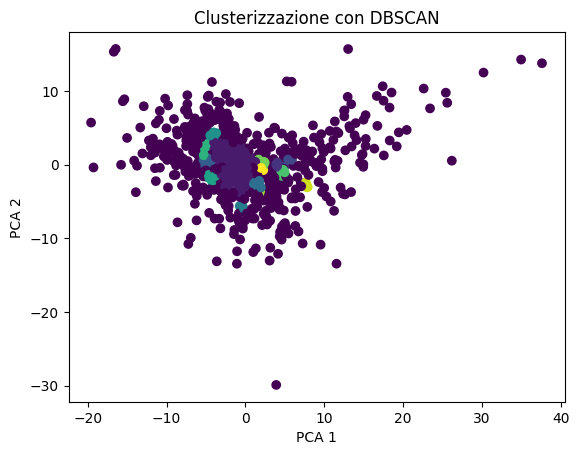

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preprocessing dei dati
features = prima_tabella.drop(columns=['paziente', 'blocco', 'Sintomatico']).values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features_scaled)

# Riduzione dimensionale con PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_imputed)

# Applica DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(features_pca)

# Visualizza i risultati di DBSCAN
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels_dbscan, cmap='viridis')
plt.title('Clusterizzazione con DBSCAN')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


Silhouette Score per 2 clusters: 0.3954150597209888
Silhouette Score per 3 clusters: 0.34414495781518395
Silhouette Score per 4 clusters: 0.3252020977670702
Silhouette Score per 5 clusters: 0.27531505003250717
Silhouette Score per 6 clusters: 0.3167324785098368
Silhouette Score per 7 clusters: 0.3364892791230611
Silhouette Score per 8 clusters: 0.2908400846859936
Silhouette Score per 9 clusters: 0.2945750935062581
Silhouette Score per 10 clusters: 0.3006600134267146
Silhouette Score per 11 clusters: 0.30269683810265
Silhouette Score per 12 clusters: 0.29529682364354876
Silhouette Score per 13 clusters: 0.2943970700696902
Silhouette Score per 14 clusters: 0.2968351531377222
Silhouette Score per 15 clusters: 0.29709275256897305
Silhouette Score per 16 clusters: 0.2769083974187469
Silhouette Score per 17 clusters: 0.2794969663650803
Silhouette Score per 18 clusters: 0.27045765691034224
Silhouette Score per 19 clusters: 0.2711556350746963
Silhouette Score per 20 clusters: 0.273820542772340

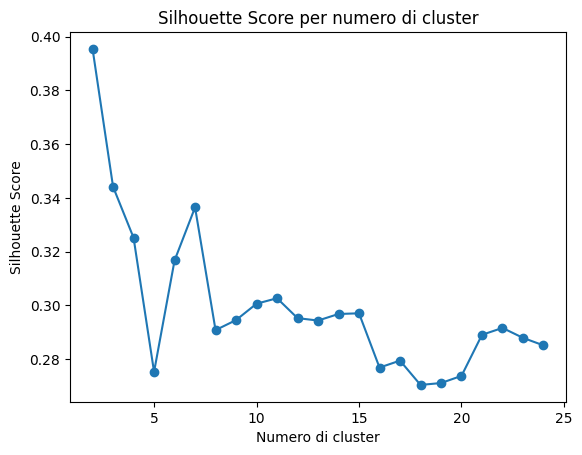

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Preprocessing
features = prima_tabella.drop(columns=['paziente', 'blocco', 'Sintomatico']).values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features_scaled)

pca = PCA(n_components=4)
features_pca = pca.fit_transform(features_imputed)

# Lista per memorizzare i silhouette scores
silhouette_scores = []

# Prova il numero di cluster da 2 a 10
for n_clusters in range(2, 25):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_pca)
    score = silhouette_score(features_pca, labels)
    silhouette_scores.append(score)

# Visualizza il Silhouette Score per ogni numero di cluster
for i, score in enumerate(silhouette_scores, start=2):
    print(f"Silhouette Score per {i} clusters: {score}")

# Mostra i risultati graficamente
plt.plot(range(2, 25), silhouette_scores, marker='o')
plt.title('Silhouette Score per numero di cluster')
plt.xlabel('Numero di cluster')
plt.ylabel('Silhouette Score')
plt.show()


## silhoutte e gomito
indicano che i punti si classificano bene per 3 fold

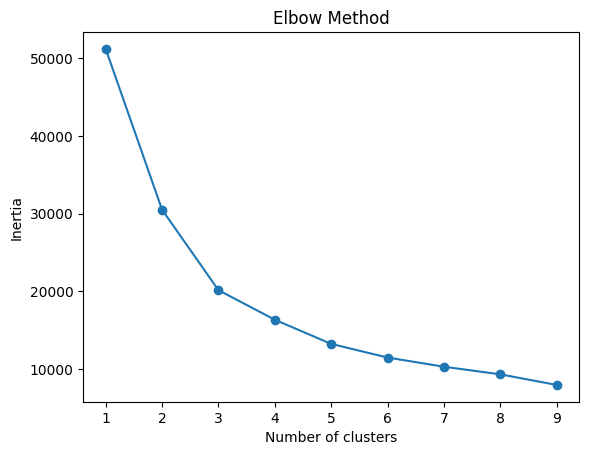

Silhouette Score: 0.33516872292578603


In [37]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(features_pca, labels)
print(f"Silhouette Score: {silhouette_avg}")


## t_sne
Cluster dominante: Il cluster viola potrebbe rappresentare un gruppo omogeneo o una distribuzione continua di dati con variazioni minime all'interno del gruppo.

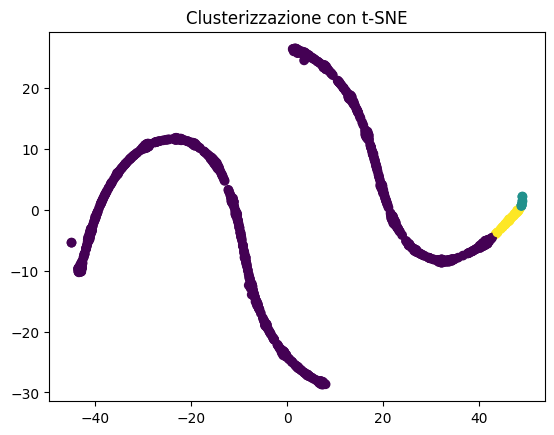

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_imputed)

plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis')
plt.title('Clusterizzazione con t-SNE')
plt.show()


In [19]:
explained_variance = pca.explained_variance_ratio_
print(f"Varianza spiegata dalle prime due componenti: {explained_variance[:2].sum()}")


Varianza spiegata dalle prime due componenti: 0.999999972390632


In [23]:
# Aggiungi i cluster alla tabella originale
prima_tabella['Cluster'] = labels

# Seleziona solo le colonne numeriche
numeric_columns = prima_tabella.select_dtypes(include=[np.number])

# Calcola la media delle features per ogni cluster
cluster_means = numeric_columns.groupby(prima_tabella['Cluster']).mean()

# Stampa i risultati
print(cluster_means)


              blocco  original_shape_Elongation  original_shape_Flatness  \
Cluster                                                                    
0        2159.734057                   0.616923                 0.328281   
1        2261.444444                   0.657855                 0.515786   
2        2124.771429                   0.723591                 0.550439   

         original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
Cluster                                                                   
0                              7.067747                       20.166469   
1                             15.851076                       30.817565   
2                             17.310997                       31.724409   

         original_shape_Maximum2DDiameterColumn  \
Cluster                                           
0                                     18.975449   
1                                     32.306085   
2                                     3

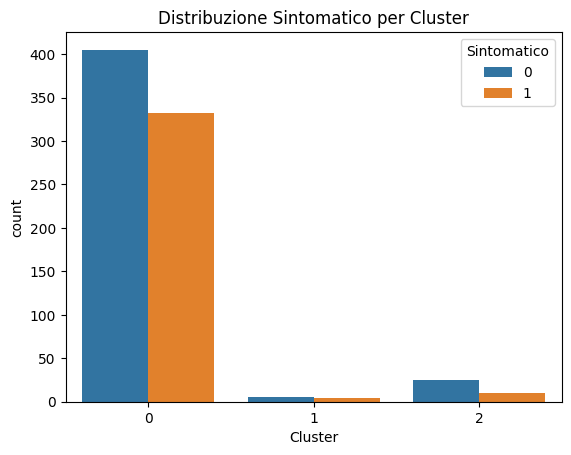

In [22]:
import seaborn as sns

# Conta il numero di pazienti sintomatici in ogni cluster
sns.countplot(x='Cluster', hue='Sintomatico', data=prima_tabella)
plt.title('Distribuzione Sintomatico per Cluster')
plt.show()


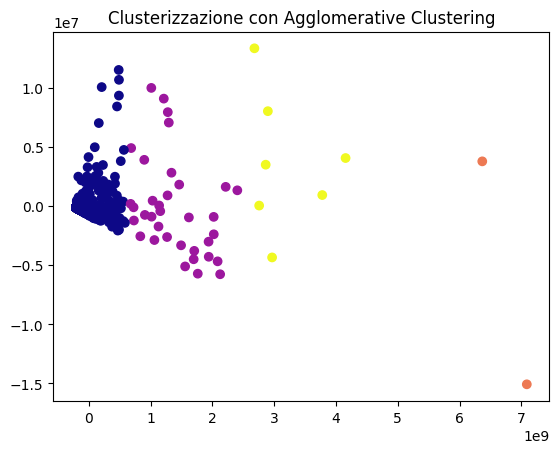

In [28]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(features_pca)

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=agg_labels, cmap='plasma')
plt.title('Clusterizzazione con Agglomerative Clustering')
plt.show()


In [31]:
# Aggiungi le etichette del clustering al DataFrame
prima_tabella['Cluster'] = labels

# Conta i pazienti sintomatici e asintomatici in ciascun cluster
conteggi_cluster = prima_tabella.groupby(['Cluster', 'Sintomatico']).size().unstack(fill_value=0)
print(conteggi_cluster)


Sintomatico    0    1
Cluster              
0            405  332
1              5    4
2             25   10
